In [ ]:
!pip install piq

In [ ]:
!pip install torchmetrics

In [46]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torchvision.transforms.functional as ttf
import piq
channel = 32
from math import exp
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.image import LearnedPerceptualImagePatchSimilarity as LPIPS
import torch.optim as optim
from tqdm.notebook import tqdm

In [47]:
print(f"Torch: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Torch: 2.1.0
cuda


In [48]:
low_dir = './low'
high_dir = './high'
low_images_path = [os.path.join(low_dir, str(i)+'.JPG') for i in range(0,740)]
high_images_path = [os.path.join(high_dir, str(i)+'.JPG') for i in range(0,740)]
print(low_images_path[0])
print(len(low_images_path))
print(high_images_path[0])
print(len(high_images_path))

./low\0.JPG
740
./high\0.JPG
740


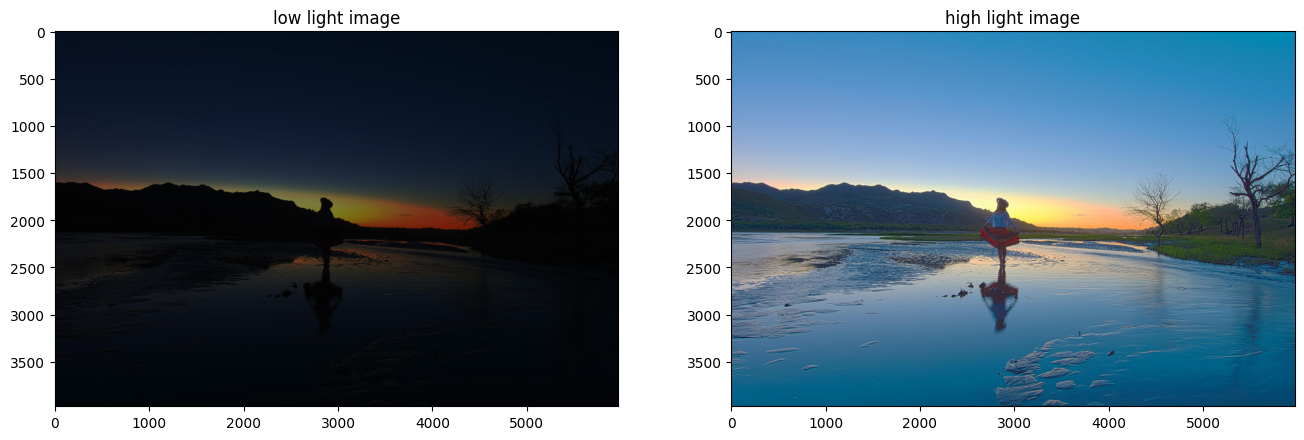

In [49]:
fig = plt.figure(figsize=(16, 12))
plt.subplot(1,2,1)
img1 = Image.open(low_images_path[0])
plt.imshow(img1)
plt.title('low light image')
plt.subplot(1,2,2)
img2 = Image.open(high_images_path[0])
plt.imshow(img2)
plt.title('high light image')
plt.show()

In [50]:
seed = 42
batch_size = 4

In [51]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [52]:
class lowlight_dataset(torch.utils.data.Dataset):
    def __init__(self, images_name, dataset_folder):
        self.image_name_list = images_name
        self.size = 256
        self.dataset_folder = dataset_folder

    def __getitem__(self, index):

        data_lowlight = Image.open(os.path.join(self.dataset_folder, 'low', self.image_name_list[index]))
        data_highlight = Image.open(os.path.join(self.dataset_folder, 'high', self.image_name_list[index]))

        data_lowlight = data_lowlight.resize((self.size,self.size), Image.LANCZOS)
        data_highlight = data_highlight.resize((self.size,self.size), Image.LANCZOS)

        data_lowlight = (np.asarray(data_lowlight)/255.0)
        data_lowlight = torch.from_numpy(data_lowlight).float()

        data_highlight = (np.asarray(data_highlight)/255.0)
        data_highlight = torch.from_numpy(data_highlight).float()

        return (data_lowlight.permute(2,0,1), data_highlight.permute(2,0,1))

    def __len__(self):
        return len(self.image_name_list)

In [53]:
images_name = [str(i)+'.JPG' for i in range(0,739)]
train_list, valid_list = train_test_split(images_name, test_size=0.3, random_state=42)
dataset_folder = './'
train_dataset = lowlight_dataset(train_list, dataset_folder)
valid_dataset = lowlight_dataset(valid_list, dataset_folder)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [54]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

In [55]:
def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

In [56]:
def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret

In [57]:
def msssim(img1, img2, window_size=11, size_average=True, val_range=None, normalize=False):
    device = img1.device
    weights = torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).to(device)
    levels = weights.size()[0]
    mssim = []
    mcs = []
    for _ in range(levels):
        sim, cs = ssim(img1, img2, window_size=window_size, size_average=size_average, full=True, val_range=val_range)
        mssim.append(sim)
        mcs.append(cs)

        img1 = F.avg_pool2d(img1, (2, 2))
        img2 = F.avg_pool2d(img2, (2, 2))

    mssim = torch.stack(mssim)
    mcs = torch.stack(mcs)

    # Normalize (to avoid NaNs during training unstable models, not compliant with original definition)
    if normalize:
        mssim = (mssim + 1) / 2
        mcs = (mcs + 1) / 2

    pow1 = mcs ** weights
    pow2 = mssim ** weights
    # From Matlab implementation https://ece.uwaterloo.ca/~z70wang/research/iwssim/
    output = torch.prod(pow1[:-1] * pow2[-1])
    return output


In [58]:
# Classes to re-use window
class SSIM2(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM2, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        return ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average)

In [59]:
class MSSSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, channel=3):
        super(MSSSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = channel

    def forward(self, img1, img2):
        # TODO: store window between calls if possible
        return msssim(img1, img2, window_size=self.window_size, size_average=self.size_average)

In [60]:
class ASFConv(nn.Module):
    def __init__(self, Ksize, inChannel):
        super(ASFConv, self).__init__()
        self.inChannel = inChannel
        pad = int((Ksize - 1))
        self.Ksize = Ksize
        toPadY = (0, 0, pad, pad)
        self.padderY = nn.ReflectionPad2d(toPadY)
        toPadX = (pad, pad, 0, 0)
        self.padderX = nn.ReflectionPad2d(toPadX)
        self.yKernel = nn.Parameter(torch.ones([self.inChannel, 1, Ksize, 1]))

        self.masky = nn.Parameter(torch.cat([torch.ones([self.inChannel, 1, Ksize, 1]),torch.zeros([self.inChannel, 1, Ksize-1, 1])], 2),requires_grad=False)
        self.maskx = nn.Parameter(torch.cat([torch.ones([self.inChannel, 1, 1, Ksize]),torch.zeros([self.inChannel, 1, 1, Ksize-1])], 3),requires_grad=False)
        self.m = (((2*self.Ksize-1)**2) / (self.Ksize**2))
        self.n = (((2*self.Ksize-1)**2) / (self.Ksize*(2*self.Ksize-1)))

    def forward(self, x):
        b,c,h,w = x.shape
        yKernel = torch.abs(self.yKernel)
        yKernel = yKernel.cumsum(dim=2)
        yKernelFlip = torch.flip(yKernel, [2])[:, :, 1:, :]
        yKernel = torch.cat((yKernel, yKernelFlip), 2)
        yKernel = yKernel / (torch.sum(yKernel, 2, keepdim=True)+1e-8)
        xKernel = yKernel.permute(0, 1, 3, 2)
        xPad = self.padderY(x)
        xPad = self.padderX(xPad)
        xPad = F.conv2d(xPad, yKernel, bias=None, padding=0, groups=self.inChannel)
        res = F.conv2d(xPad, xKernel, bias=None, padding=0, groups=self.inChannel)

        return res

In [61]:
class ARBlock(nn.Module):
    def __init__(self, Ksize, inChannel, OChannel):
        super(ARBlock, self).__init__()
        self.ASFConv = ASFConv(Ksize,inChannel)

        self.RPath = nn.Sequential(
                     nn.Conv2d(inChannel,OChannel,(3,3),1,padding=(2,2),bias=True,groups=1,dilation=2),
                     nn.ReLU(),
                     nn.Conv2d(OChannel,OChannel,(3,3),1,padding=(2,2),bias=True,groups=1,dilation=2),
                     nn.ReLU(),

        )

        self.IPath = nn.Sequential(
                     nn.Conv2d(inChannel,OChannel,(1,1),1,padding=(0,0),bias=True,groups=1),
                     nn.ReLU(),
        )

        self.fusion = nn.Sequential(
                     nn.Conv2d(inChannel*2,OChannel,(1,1),1,padding=(0,0),bias=True,groups=1),
                     nn.ReLU(),
        )

    def forward(self,x):
        b,c,h,w = x.shape
        x = x*255
        logx = torch.log(x+1)
        CSC = self.ASFConv(x)
        CSC = torch.log(CSC+1)

        refl = logx - CSC
        illu = self.IPath(CSC)

        refl = self.RPath(refl) + refl
        clear = self.fusion(torch.cat([refl,illu],1))
        return clear,CSC

In [62]:
class ARBlocks(nn.Module):
    def __init__(self,Ksize,inChannel,ouChannel):
        super(ARBlocks, self).__init__()
        self.RBP1 = ARBlock(3,inChannel,inChannel)
        self.RBP2 = ARBlock(7,inChannel,ouChannel)
        self.RBP3 = ARBlock(11,inChannel,inChannel)
        self.RBP4 = ARBlock(15,inChannel,ouChannel)
    def forward(self,x):
        RBP1,CSC1 = self.RBP1(x)
        RBP2,CSC2 = self.RBP2(x)
        RBP3,CSC3 = self.RBP3(x)
        RBP4,CSC4 = self.RBP4(x)
        return torch.cat([RBP1,RBP2,RBP3,RBP4],1),torch.cat([CSC1,CSC2,CSC3,CSC4],1)

In [63]:
class SECA(nn.Module):
    def __init__(self, channel, k_size=7, shuffle=False):
        super(SECA, self).__init__()
        self.shuffle = shuffle
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Sequential(
                                nn.Conv1d(1, channel, kernel_size=k_size, padding=(k_size - 1) // 2, bias=True),
                                nn.Conv1d(channel, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=True),
                                )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        b, c, h, w = x.size()
        if self.shuffle:
            x = x.view(b,channel,int(c/(channel)),h,w).permute(0,2,1,3,4).contiguous().view(b,c,h,w)
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

In [64]:
class make_dense(nn.Module):
    def __init__(self, nChannels, growthRate, kernel_size=3):
        super(make_dense, self).__init__()
        self.conv = nn.Conv2d(nChannels, growthRate, kernel_size=kernel_size, padding=((kernel_size-1)//2), bias=True,dilation=1)
    def forward(self, x):
        out = F.relu(self.conv(x))
        out = torch.cat((x, out), 1)
        return out

In [65]:
class RDB(nn.Module):
    def __init__(self, nChannels, nDenselayer, growthRate):
        super(RDB, self).__init__()
        nChannels_ = nChannels
        modules = []
        for i in range(nDenselayer):
            modules.append(make_dense(nChannels_, growthRate))
            nChannels_ += growthRate
        self.dense_layers = nn.Sequential(*modules)
        self.conv_1x1 = nn.Conv2d(nChannels_, nChannels, kernel_size=1, padding=0, bias=True)
    def forward(self, x):
        out = self.dense_layers(x)
        out = self.conv_1x1(out)
        out = out + x
        return out

In [66]:
class LED(nn.Module):
    def __init__(self):
        super(LED, self).__init__()

        self.baseConv1 = nn.Sequential(
                     nn.Conv2d(3,channel,5,1,padding=2,bias=True,dilation=1),
                     nn.ReLU()
        )

        self.baseConv2 = nn.Sequential(
                     nn.Conv2d(channel,3,5,1,padding=2,bias=True,dilation=1),
        )

        self.secondConv1 = nn.Sequential(
                     nn.Conv2d(3+3,channel,3,1,padding=1,bias=True,dilation=1),
        )


        self.RBD1 = RDB(channel,2,int(channel/2))
        self.RBD2 = RDB(channel,2,int(channel/2))
        self.RBD3 = RDB(channel,2,int(channel/2))

    def forward(self, x):

        bsConv1 = self.baseConv1(torch.cat([x],1))
        RBD1 = self.RBD1(bsConv1)
        RBD2 = self.RBD2(RBD1)
        base = self.baseConv2(RBD2) + x

        scConv1 = self.secondConv1(torch.cat([base,x],1))
        scConv1 = F.relu(scConv1)
        return scConv1,base

In [67]:
class SurroundNet(nn.Module):
    def __init__(self):
        super(SurroundNet, self).__init__()
        self.LED = LED()
        self.ARBlocks = ARBlocks(5,channel,channel)
        self.SECA = SECA(((channel)*4)+channel,9)
        self.resConv = nn.Sequential(
                     nn.Conv2d(((channel)*4)+channel,3,5,1,padding=2,bias=True),
        )

    def forward(self,x):
        b,c,h,w = x.shape
        features,base = self.LED(x)
        ARBlocks,_ = self.ARBlocks(features) #1
        SECA = self.SECA(torch.cat([ARBlocks,features],1))
        res = self.resConv(SECA)
        res = res+base
        return res

In [68]:
class L1CharbonnierLoss(torch.nn.Module):
    def __init__(self):
        super(L1CharbonnierLoss, self).__init__()
        self.eps = 1e-3

    def forward(self, X, Y):
        diff = torch.add(X, -Y)
        error = torch.sqrt(diff * diff + self.eps)
        loss = torch.mean(error)
        return loss

In [69]:
class SurroundNetLoss(nn.Module):
    def __init__(self):
        super(SurroundNetLoss, self).__init__()
        self.DISTSLoss1 = piq.DISTS()
        self.SSIMLoss1 = SSIM2(val_range=1.)
        self.l1Loss = L1CharbonnierLoss()

    def forward(self, res, highImg, base, LEDImg):
        self.CLoss1 = 1-self.SSIMLoss1(res,highImg) + self.l1Loss(res,highImg) + self.DISTSLoss1(res,highImg)
        self.CLoss2 = 1-self.SSIMLoss1(base,LEDImg) + self.l1Loss(base,LEDImg) + self.DISTSLoss1(base,LEDImg)

        self.loss =  self.CLoss1 + self.CLoss2
        return self.loss

In [70]:
def get_metrics(enh_img: torch.Tensor, gt_img: torch.Tensor, device: str='cpu'):
    '''
        Функция для измерения метрик. Расчитывает среднее значение по сэмплу
        Arguments:
            :enh_img: изображения после обработки
            :gt_img: ground-truth изображения
            :device: cpu/cuda
    '''
    # значение каждого пикселя должно быть в интервале от 0.0 до 1.0
    enh_img = enh_img.to(device)/255 if enh_img.max() > 1 else enh_img.to(device)
    gt_img = gt_img.to(device)/255 if gt_img.max() > 1 else gt_img.to(device)
    # PSNR
    psnr = PSNR(data_range=1.0).to(device)
    psnr_score = psnr(enh_img, gt_img).item()
    # SSIM
    ms_ssim = SSIM(data_range=1.0).to(device)
    ssim_score = ms_ssim(enh_img, gt_img).item()
    # LILPS
    lpips = LPIPS('alex').to(device)
    lpips_score = lpips(enh_img, gt_img).item()
    return psnr_score, ssim_score, lpips_score

In [26]:
def train(model_,epochs,lr):
    train_loss = []
    outputs_train = []
    targets_train = []
    psnr_list = np.array([])
    ssim_list = np.array([])
    lpips_list = np.array([])
    # loss function
    SNloss = SurroundNetLoss()
    # optimizer
    optimizer = optim.Adam(model_.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_psnr = 0
        epoch_ssim = 0
        epoch_lpips = 0

        for lowlight_img, gt_img in tqdm(train_dataloader):
            lowlight_img = lowlight_img.to(device)

            gt_img = gt_img.to(device)

            led_model = LED().to(device)
            scConv1, base = led_model(lowlight_img)
            un = torch.mean(gt_img)
            thn = torch.var(gt_img)
            ull = torch.mean(lowlight_img)
            thll = torch.var(lowlight_img)
            LEDImg = ((gt_img-un)/thn)*ull+thll

            output = model_(lowlight_img)

            loss = SNloss(res=output, highImg=gt_img, base=base, LEDImg=LEDImg)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            psnr_score, ssim_score, lpips_score = get_metrics(output, gt_img, device=device)

            epoch_psnr += psnr_score / len(train_dataloader)
            epoch_ssim += ssim_score / len(train_dataloader)
            epoch_lpips += lpips_score / len(train_dataloader)
            epoch_loss += loss / len(train_dataloader)

        train_loss.append(epoch_loss)
        psnr_list = np.append(psnr_list, psnr_score)
        ssim_list = np.append(ssim_list, ssim_score)
        lpips_list = np.append(lpips_list, lpips_score)
        print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - psnr: {epoch_psnr:.4f} - ssim: {epoch_ssim:.4f} - lpips: {epoch_lpips:.4f}\n")


    print("Epoch:{}".format(epoch+1))
    print("Loss value in the last epoch of training is:{}".format(epoch_loss))
    print(f'PSNR: {psnr_list.mean()}\nSSIM: {ssim_list.mean()}\nLPIPS: {lpips_list.mean()}')

In [27]:
model1 = SurroundNet().to(device)
epochs = 50
lr = 1e-5

In [28]:
train(model1, epochs, lr)

D:\Anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.7500 - psnr: 23.1870 - ssim: 0.4718 - lpips: 0.4171



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.3896 - psnr: 26.9352 - ssim: 0.6616 - lpips: 0.3120



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.3393 - psnr: 27.3423 - ssim: 0.6960 - lpips: 0.2781



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.2878 - psnr: 27.6447 - ssim: 0.7181 - lpips: 0.2558



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 5 - loss : 2.2658 - psnr: 27.8054 - ssim: 0.7327 - lpips: 0.2381



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 6 - loss : 2.2404 - psnr: 27.9422 - ssim: 0.7424 - lpips: 0.2249



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 7 - loss : 2.2307 - psnr: 28.1597 - ssim: 0.7508 - lpips: 0.2161



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 8 - loss : 2.2003 - psnr: 28.3163 - ssim: 0.7578 - lpips: 0.2065



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 9 - loss : 2.1904 - psnr: 28.3780 - ssim: 0.7628 - lpips: 0.1993



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 10 - loss : 2.1911 - psnr: 28.4293 - ssim: 0.7673 - lpips: 0.1938



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 11 - loss : 2.1850 - psnr: 28.3162 - ssim: 0.7695 - lpips: 0.1904



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 12 - loss : 2.1608 - psnr: 28.5569 - ssim: 0.7741 - lpips: 0.1845



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 13 - loss : 2.1557 - psnr: 28.5322 - ssim: 0.7769 - lpips: 0.1802



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 14 - loss : 2.1555 - psnr: 28.5919 - ssim: 0.7786 - lpips: 0.1776



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 15 - loss : 2.1636 - psnr: 28.6857 - ssim: 0.7811 - lpips: 0.1743



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 16 - loss : 2.1604 - psnr: 28.5947 - ssim: 0.7795 - lpips: 0.1753



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 17 - loss : 2.1430 - psnr: 28.7223 - ssim: 0.7823 - lpips: 0.1702



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 18 - loss : 2.1491 - psnr: 28.6853 - ssim: 0.7853 - lpips: 0.1678



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 19 - loss : 2.1540 - psnr: 28.7578 - ssim: 0.7864 - lpips: 0.1667



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 20 - loss : 2.1344 - psnr: 28.7294 - ssim: 0.7866 - lpips: 0.1649



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 21 - loss : 2.1415 - psnr: 28.8505 - ssim: 0.7887 - lpips: 0.1623



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 22 - loss : 2.1377 - psnr: 28.8888 - ssim: 0.7899 - lpips: 0.1608



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 23 - loss : 2.1237 - psnr: 28.8470 - ssim: 0.7901 - lpips: 0.1591



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 24 - loss : 2.1370 - psnr: 28.9081 - ssim: 0.7891 - lpips: 0.1588



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 25 - loss : 2.1322 - psnr: 29.0260 - ssim: 0.7915 - lpips: 0.1566



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 26 - loss : 2.1262 - psnr: 29.0123 - ssim: 0.7927 - lpips: 0.1546



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 27 - loss : 2.1198 - psnr: 29.0271 - ssim: 0.7939 - lpips: 0.1533



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 28 - loss : 2.1160 - psnr: 29.0604 - ssim: 0.7949 - lpips: 0.1519



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 29 - loss : 2.1130 - psnr: 29.1674 - ssim: 0.7955 - lpips: 0.1512



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 30 - loss : 2.1092 - psnr: 29.1430 - ssim: 0.7960 - lpips: 0.1493



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 31 - loss : 2.1107 - psnr: 29.2054 - ssim: 0.7973 - lpips: 0.1485



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 32 - loss : 2.1039 - psnr: 29.2462 - ssim: 0.7977 - lpips: 0.1479



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 33 - loss : 2.1140 - psnr: 29.3562 - ssim: 0.7989 - lpips: 0.1466



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 34 - loss : 2.1045 - psnr: 29.2914 - ssim: 0.7999 - lpips: 0.1460



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 35 - loss : 2.1107 - psnr: 29.4450 - ssim: 0.8005 - lpips: 0.1456



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 36 - loss : 2.0985 - psnr: 29.5279 - ssim: 0.8019 - lpips: 0.1443



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 37 - loss : 2.0981 - psnr: 29.5296 - ssim: 0.8011 - lpips: 0.1444



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 38 - loss : 2.0917 - psnr: 29.6204 - ssim: 0.8035 - lpips: 0.1430



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 39 - loss : 2.0906 - psnr: 29.6620 - ssim: 0.8044 - lpips: 0.1417



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 40 - loss : 2.0912 - psnr: 29.8144 - ssim: 0.8053 - lpips: 0.1415



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 41 - loss : 2.0891 - psnr: 29.8048 - ssim: 0.8056 - lpips: 0.1408



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 42 - loss : 2.0984 - psnr: 29.9258 - ssim: 0.8066 - lpips: 0.1408



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 43 - loss : 2.0830 - psnr: 30.0586 - ssim: 0.8084 - lpips: 0.1394



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 44 - loss : 2.0850 - psnr: 30.1897 - ssim: 0.8098 - lpips: 0.1387



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 45 - loss : 2.0758 - psnr: 30.0791 - ssim: 0.8102 - lpips: 0.1377



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 46 - loss : 2.0840 - psnr: 30.2422 - ssim: 0.8112 - lpips: 0.1374



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 47 - loss : 2.0781 - psnr: 30.2654 - ssim: 0.8107 - lpips: 0.1375



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 48 - loss : 2.0749 - psnr: 30.3556 - ssim: 0.8125 - lpips: 0.1363



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 49 - loss : 2.0818 - psnr: 30.4246 - ssim: 0.8135 - lpips: 0.1352



  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 50 - loss : 2.0654 - psnr: 30.4799 - ssim: 0.8136 - lpips: 0.1356

Epoch:49
Loss value in the last epoch of training is:2.065397262573242
PSNR: 19.110619144439696
SSIM: 0.8066890966892243
LPIPS: 0.16193539656698705


In [30]:
torch.save(model1.state_dict(), './model1_params.pth')

In [74]:
psnr_list_val = np.array([])
ssim_list_val = np.array([])
lpips_list_val = np.array([])
with torch.no_grad():
    for lowlight_img, gt_img in valid_dataloader:
        lowlight_img = lowlight_img.to(device)
        gt_img = gt_img.to(device)
        val_output = model1(lowlight_img)
        psnr_score, ssim_score, lpips_score = get_metrics(val_output, gt_img, device=device)
        psnr_list_val = np.append(psnr_list_val, psnr_score)
        ssim_list_val = np.append(ssim_list_val, ssim_score)
        lpips_list_val = np.append(lpips_list_val, lpips_score)

print(f'PSNR_val: {psnr_list_val.mean()}\nSSIM_val: {ssim_list_val.mean()}\nLPIPS_val: {lpips_list_val.mean()}')

PSNR_val: 5.788024170058114
SSIM_val: 0.009190532012975641
LPIPS_val: 0.8110551887324878


# Test

In [71]:
test_list = [str(i)+'.JPG' for i in range(0,106)]
dataset_folder_test= './test_set'
test_dataset = lowlight_dataset(test_list, dataset_folder_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [72]:
print(f"length of data: {len(test_dataset)}")
print(f"length of data loader: {len(test_dataloader)}")

length of data: 106
length of data loader: 27


In [73]:
model2 = SurroundNet().to(device)
model2.load_state_dict(torch.load('model1_params.pth'))

<All keys matched successfully>

In [30]:
import time
inference_time = 0
for i in range(batch_size):
    lowlight_img, gt_img = test_dataloader.dataset[i]
    lowlight_img = lowlight_img.unsqueeze(0)
    lowlight_img = lowlight_img.to(device)

    torch.cuda.synchronize()
    start = time.time()

    output = model2(lowlight_img)

    torch.cuda.synchronize()
    end = time.time()

    inference_time += (end - start)
print("Время инференса модели при обработке одного изображения：", inference_time/batch_size, "с")

Время инференса модели при обработке одного изображения： 0.10976803302764893 с


In [75]:
psnr_list_test = np.array([])
ssim_list_test = np.array([])
lpips_list_test = np.array([])
with torch.no_grad():
    for lowlight_img, gt_img in test_dataloader:
        lowlight_img = lowlight_img.to(device)
        gt_img = gt_img.to(device)
        test_output = model2(lowlight_img)
        psnr_score, ssim_score, lpips_score = get_metrics(test_output, gt_img, device=device)
        psnr_list_test = np.append(psnr_list_test, psnr_score)
        ssim_list_test = np.append(ssim_list_test, ssim_score)
        lpips_list_test = np.append(lpips_list_test, lpips_score)

print(f'PSNR_test: {psnr_list_test.mean()}\nSSIM_test: {ssim_list_test.mean()}\nLPIPS_test: {lpips_list_test.mean()}')

PSNR_test: 6.099854380996139
SSIM_test: 0.03576288441265071
LPIPS_test: 0.7807233973785683


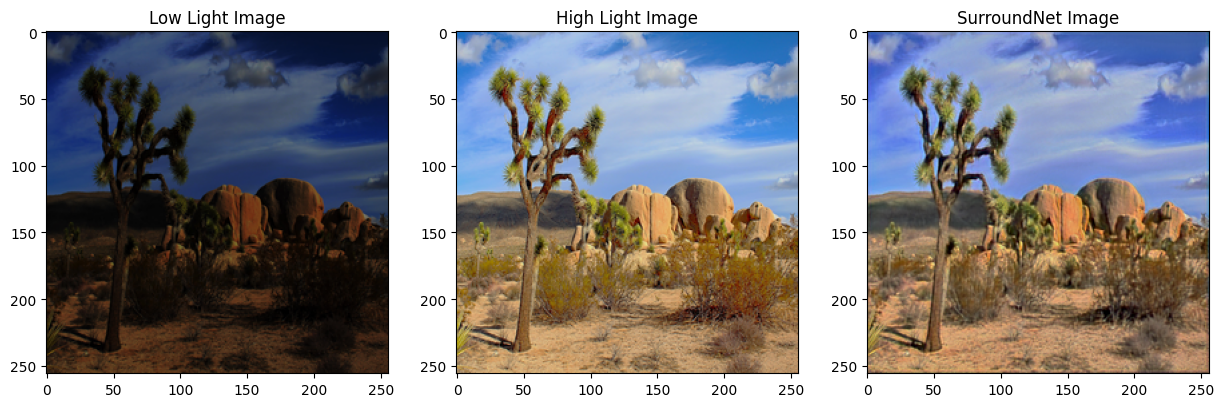

In [95]:
import matplotlib.pyplot as plt

data_lowlight0, data_highlight0 = test_dataset[0]
data_lowlight0_ = data_lowlight0.permute(1, 2, 0).numpy()
data_highlight0_ = data_highlight0.permute(1, 2, 0).numpy()
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(data_lowlight0_)
plt.title('Low Light Image')

plt.subplot(1, 3, 2)
plt.imshow(data_highlight0_)
plt.title('High Light Image')

plt.subplot(1, 3, 3)
test_output0 = np.clip(model1(test_dataloader.dataset[0][0].unsqueeze(0).to(device)).cpu()[0].detach().permute(1, 2, 0).numpy(), 0, 1)
plt.imshow(test_output0)
plt.title('SurroundNet Image')

plt.show()